# CER Electricity Revised March 2012

## Import libaries

In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", context="paper") # imporved plt styles

from tqdm.notebook import tqdm as tqdm
from wwo_hist import retrieve_hist_data

In [2]:
import tikzplotlib

# Function definitions

In [3]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [4]:
def dowload_weather_data(api_key,
                         frequency,
                         start_date,
                         end_date):
    location_list = ['Dublin']
    hist_weather_data = retrieve_hist_data(api_key,
                                           location_list,
                                           start_date,
                                           end_date,
                                           frequency,
                                           store_df = True)
    return hist_weather_data

## Load data

In [106]:
data_path=os.path.join("../data",'CER Electricity Revised March 2012')

tikz_path='../doc/thesis/tikz/generated'
csv_path='../doc/thesis/csv'

In [107]:

files=[file for file in os.listdir(data_path) if file.startswith('File') and file.endswith('.txt')]
files

['File6.txt', 'File1.txt', 'File5.txt', 'File2.txt', 'File4.txt', 'File3.txt']

In [7]:
data=dict()
it=tqdm(files)
for f in it:
    it.set_description(f"reading file: {f}")

    file_name=os.path.join(data_path, f)
    df=pd.read_csv(file_name,
          header=None,
          names=["id","date_time","load"],
          #index_col=["id","date_time"],
          #parse_dates=[1],
          #date_parser=date_parser,
          sep="\s+")
    
    # parse timestamp
    it.set_description("generating timestamps")
    # digit 1-3 (day 1 = 2019/1/1)
    day_code=df.date_time // 100 - 1
    # digit 4-5 (1 = 00:00:00 - 00:29:59)
    time_code=df.date_time % 100 - 1

    date=pd.to_datetime(day_code,
                        unit='D',
                        origin=pd.Timestamp('2009-01-01'),
                        infer_datetime_format=True)
    #time_delta=pd.to_timedelta(time_code*30,
    #            unit='m')
    #df.date_time=date+time_delta
    df.date_time=(date.astype('int') // (10**9*60*60)).astype('uint32')
    df.rename(columns={'date_time':'date'},inplace=True)
    #df['weekday']=date.dt.weekday
    
    # reduce mem footprint
    it.set_description("reduce mem footprint")
    df['minute']=time_code#.astype('uint8')
    df.id=df.id.astype('uint16')
    
    # replace all invalid (0) fileds with NaN
    df.load.replace(0.0,np.nan,inplace=True)

    data[f]=df

del df,day_code,time_code,date

In [8]:
file_name=os.path.join(data_path, 'SME and Residential allocations.txt')
df_categories=pd.read_csv(file_name,
      dtype={"Id":'uint16',"Code":"uint8"},
      sep="\s+")
#data[f]=df
#categories = pd.Categorical.from_codes(
#    df_categories.Code - 1,
#    ['residential','enterprise','other']
#)
df_categories.columns = df_categories.columns.str.lower()
df_categories.head()

,id,code
0,1000,3
1,1001,3
2,1002,1
3,1003,1
4,1004,1


## Prepare data

In [9]:
data=pd.concat(data.values())

In [10]:
f'There are {len(data.id.unique())} differnt assets in the dataset'

'There are 6435 differnt assets in the dataset'

In [11]:
mem_usage(data)

'4520.22 MB'

## Review data metrics

In [12]:
f'there are {data.isnull().load.sum()} missing data points'

'there are 1557479 missing data points'

In [13]:
f'There are {data.isnull().load.sum()} of {len(data)} ({data.isnull().load.sum()/len(data)*100:.3f}%) NaN records'

'There are 1557479 of 157992996 (0.986%) NaN records'

In [14]:
data[data.load <= 0.0].any()

id        False
date      False
load      False
minute    False
dtype: bool

In [15]:
data.load.describe()

count    1.564355e+08
mean     7.126769e-01
std      1.491097e+00
min      1.000000e-03
25%      1.280000e-01
50%      2.800000e-01
75%      6.960000e-01
max      6.681500e+01
Name: load, dtype: float64

## Date Cleaning

### drop all *non residential* ids

In [16]:
residential_ids=df_categories[df_categories.code == 1].id

In [17]:
f'There are {len(residential_ids.unique())} differnt residential assets in the dataset'

'There are 4225 differnt residential assets in the dataset'

In [18]:
data=data.loc[data.id.isin(residential_ids)]
#drop_idx=drop_ids[drop_ids].index.drop_duplicates()
#drop_idx

In [19]:
## Merge with categories
#data.drop(drop_idx,inplace=True)
#del df_categories
data.head()

,id,date,load,minute
0,6496,346584,2.958,19
1,6496,346584,1.443,20
2,6496,346584,0.131,21
3,6496,346584,0.144,23
4,6496,346584,0.208,24


In [20]:
mem_usage(data)

'3109.32 MB'

In [21]:
data.dtypes

id         uint16
date       uint32
load      float64
minute      int64
dtype: object

In [22]:
data.set_index([10000*data.date+data.id],inplace=True)

### Delete incomplete days

In [23]:
num_duplicates=data.groupby(data.index).size()

In [24]:
dup_idx=num_duplicates[num_duplicates!=48]
dup_idx=dup_idx.index.drop_duplicates()
dup_idx

UInt64Index([3490081002, 3490081003, 3490081004, 3490081005, 3490081006,
             3490081008, 3490081009, 3490081013, 3490081014, 3490081015,
             ...
             3579127433, 3579127434, 3579127435, 3579127436, 3579127437,
             3579127438, 3579127440, 3579127441, 3579127442, 3579127443],
            dtype='uint64', length=12675)

In [25]:
f'There are {len(dup_idx)} of {len(num_duplicates)} ({len(dup_idx)/len(num_duplicates)*100}%) days incomplete'

'There are 12675 of 2263965 (0.5598584783775368%) days incomplete'

In [26]:
data.drop(dup_idx,inplace=True)

In [27]:
mem_usage(data)

'3091.68 MB'

### Delete Days with NaNs

In [28]:
# get index of all days with NaNs
nan_idx=data[data.load.isnull()].index.drop_duplicates()
nan_idx

UInt64Index([3465846864, 3465606864, 3466566864, 3466086864, 3466326864,
             3466086209, 3466566209, 3465366209, 3465606209, 3466326209,
             ...
             3593043369, 3593043009, 3592083594, 3592323594, 3592563594,
             3592803594, 3593043594, 3593283594, 3593523594, 3593763594],
            dtype='uint64', length=40899)

In [29]:
f'There are {len(nan_idx)} days of {len(data.index.unique())} ({len(nan_idx)/len(data.index.unique())*100:.3f}%) containing at least one NaN records'

'There are 40899 days of 2251290 (1.817%) containing at least one NaN records'

In [30]:
data.drop(nan_idx,inplace=True)

In [31]:
mem_usage(data)

'3035.51 MB'

## Further Data Anaysis 

### Set date_time index

In [34]:
data.date=pd.to_datetime(data.date,
                         unit='h',
                         infer_datetime_format=True)
data.date+=pd.to_timedelta(data.minute*30,
                            unit='m')
data.rename(columns={'date':'date_time'},inplace=True)

In [35]:
data.drop(['minute'],axis=1,inplace=True)
#data.reset_index(drop=True,inplace=True)
#data.set_index(['date_time', 'id'],inplace=True)

In [36]:
start_date,end_date=data.date_time.min(),data.date_time.max()
f'data ranges from {start_date} to {end_date}'

'data ranges from 2009-07-14 00:00:00 to 2010-12-31 23:30:00'

In [37]:
mem_usage(data)

'2630.78 MB'

In [38]:
months=len(data.date_time.dt.to_period('M').unique())
days=len(data.date_time.dt.date.unique())

In [39]:
f'there are {days} days ({months}) months of data'

'there are 533 days (18) months of data'

### How much assets per group?

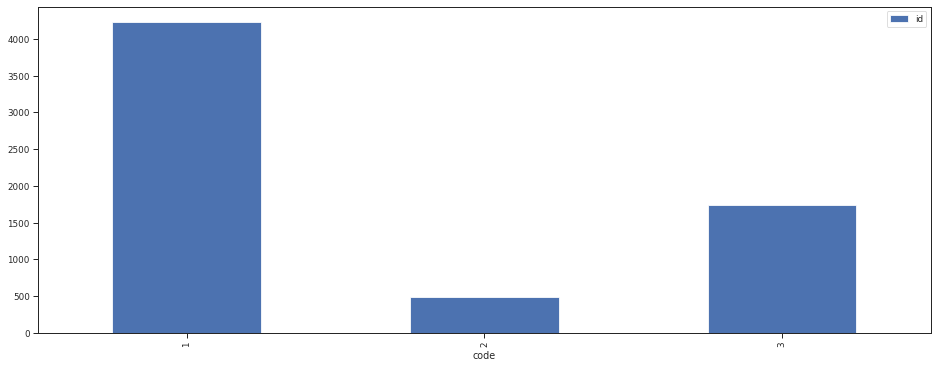

In [40]:
df_categories.groupby('code').count().plot.bar(figsize=(16,6))

In [41]:
for c in sorted(df_categories.code.unique()):
    print(c,df_categories[df_categories.code==c].id.count())

1 4225
2 485
3 1735


In [42]:
file_path=os.path.join(tikz_path,'record_per_cat.tex')
lines=['\\addplot[draw=RoyalBlue,fill=RoyalBlue!25] coordinates {']
for c in sorted(df_categories.code.unique()):
    count=df_categories[df_categories.code==c].id.count()
    lines.append(str((c,count)))
lines.append(str((c+1,count)))

lines.append('};')
    
with open(file_path, 'w+') as f:
    f.write('\n'.join(lines))

### How much datapoints per id?

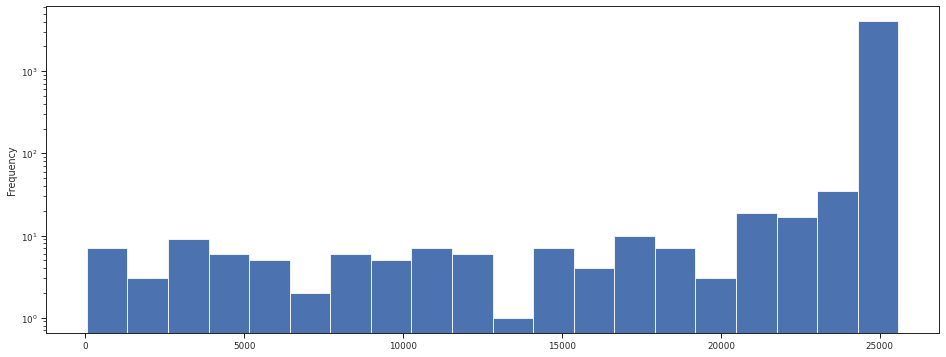

In [43]:
load_count=data.groupby('id').load.count()
load_count.plot.hist(bins = 20, log = True, figsize=(16,6))

### How much datapoints per year?

In [44]:
count_per_year=data.groupby(data.date_time.dt.year).load.count()
count_per_year/len(data.load)

date_time
2009    0.318956
2010    0.681044
Name: load, dtype: float64

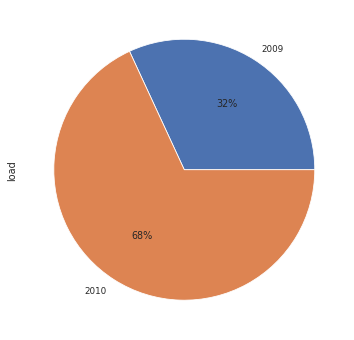

In [45]:
count_per_year.plot.pie(autopct='%1.0f%%', figsize=(6,6))

### How much datapoints per month?

In [46]:
#fig, ax = plt.figure(figsize=(16,16))
count_per_month=data.groupby([data.date_time.dt.year,data.date_time.dt.month]).load.count()

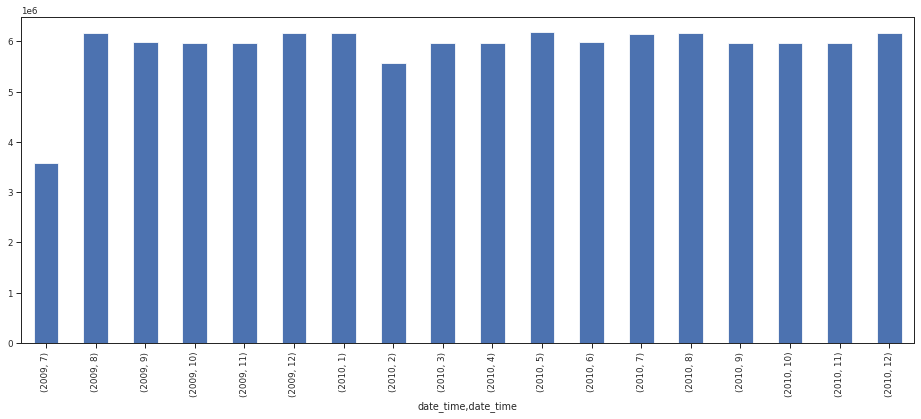

In [47]:
count_per_month.plot.bar(figsize=(16,6))

In [48]:
hist=np.histogram(load_count,bins=10)

file_path=os.path.join(tikz_path,'records_per_month.tex')
lines=['\\addplot[draw=RoyalBlue,fill=RoyalBlue!25] coordinates {']

for d,c in enumerate(count_per_month):
    lines.append(str((d,c)))
lines.append(str((d,c)))
lines.append('};')
    
with open(file_path, 'w+') as f:
    f.write('\n'.join(lines))

## Records per asset

In [49]:
min_records=48*30*17

In [50]:
size_ids=data.groupby('id').size()
num_low_data=(size_ids <= min_records).sum()

In [51]:
f'There are {num_low_data} of {len(data.id.unique())} ({num_low_data/len(data.id.unique())*100:.3f}%) asets with less than 17 months of data'

'There are 167 of 4225 (3.953%) asets with less than 17 months of data'

In [52]:
low_data_ids=size_ids[size_ids <= min_records].index
low_data_ids

UInt64Index([1045, 1060, 1069, 1112, 1161, 1262, 1316, 1329, 1389, 1453,
             ...
             7067, 7104, 7146, 7234, 7239, 7252, 7279, 7370, 7413, 7438],
            dtype='uint64', name='id', length=167)

### How much records per asset?

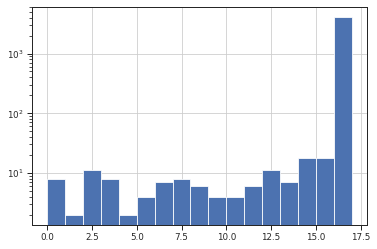

In [53]:
(size_ids//48//30).hist(log=True, bins=17)

In [54]:
file_path=os.path.join(tikz_path,'record_hist.tex')
lines=['\\addplot[draw=RoyalBlue,fill=RoyalBlue!25] coordinates {']
hist = np.histogram(size_ids//48//30, bins=17)
for a,m in zip(*hist):
    lines.append(str((int(m)+1,a)))
lines.append(str((int(m)+2,a)))
lines.append('};')
    
with open(file_path, 'w+') as f:
    f.write('\n'.join(lines))

### Delete assets with less than 17 months of data 

In [55]:
data=data[~data.id.isin(low_data_ids)]

In [56]:
mem_usage(data)

'2563.63 MB'

In [57]:
f'There are {len(data.id.unique())} assets, with a total of {len(data.load)} records left in the dataset'

'There are 4058 assets, with a total of 103390608 records left in the dataset'

## Further Analisis of Remeining Data

### Days Recorded

In [58]:
load_count_days=data.groupby('id').load.count()//48

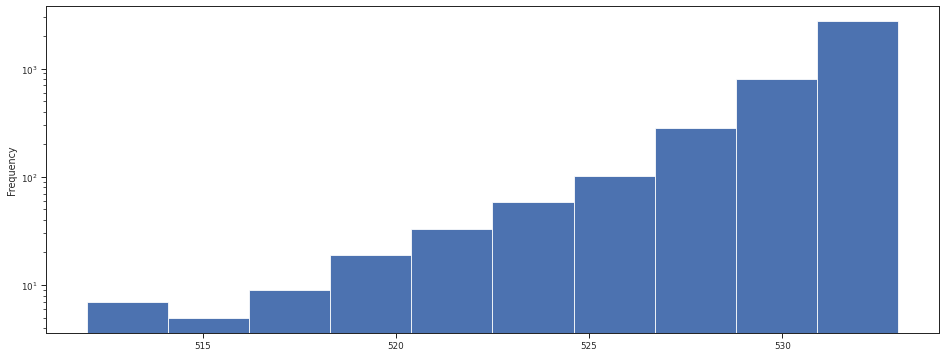

In [59]:
load_count_days.plot.hist(bins = 10, log=True, figsize=(16,6))

In [60]:
hist=np.histogram(load_count_days,bins=10)

file_path=os.path.join(tikz_path,'records_per_asset.tex')
lines=['\\addplot[draw=RoyalBlue,fill=RoyalBlue!25] coordinates {']

for a,m in zip(*hist):
    lines.append(str((int(m),a)))
lines.append(str((int(m)+2,a)))
lines.append('};')
    
with open(file_path, 'w+') as f:
    f.write('\n'.join(lines))

### Mean Load per Day?

In [61]:
mean_load=data.groupby('date_time').load.mean().to_frame()

In [62]:
daily_load=mean_load.groupby(mean_load.index.date).sum()

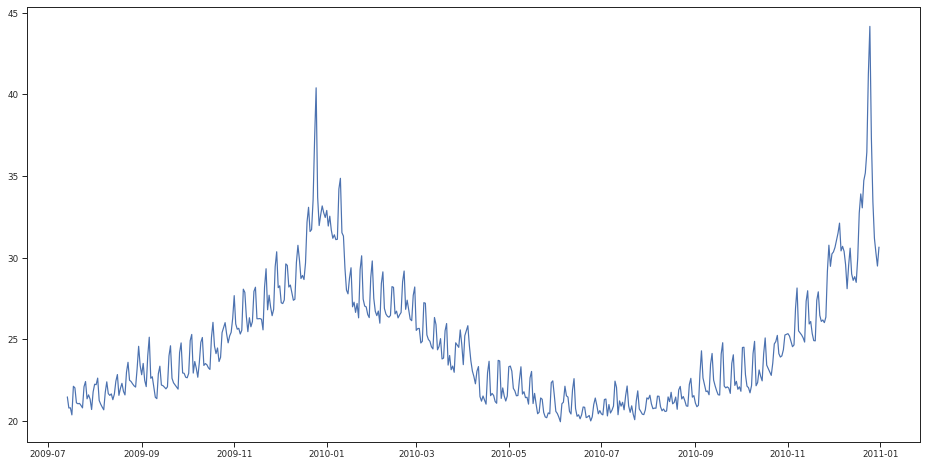

In [63]:
daily_load.plot(figsize=(16,8), legend=False)
#tikzplotlib.clean_figure()
file_path=os.path.join(tikz_path,'daily_load.tex')
tikzplotlib.save(
    file_path,
    strict=False,
    add_axis_environment=False
    #axis_height=".8\\textheight",
    #axis_width=".8\\textwidth",
    #extra_axis_parameters=['forecast plot style']
)

In [64]:
monthly_avg_load=mean_load.resample('D').sum().resample('M').mean()

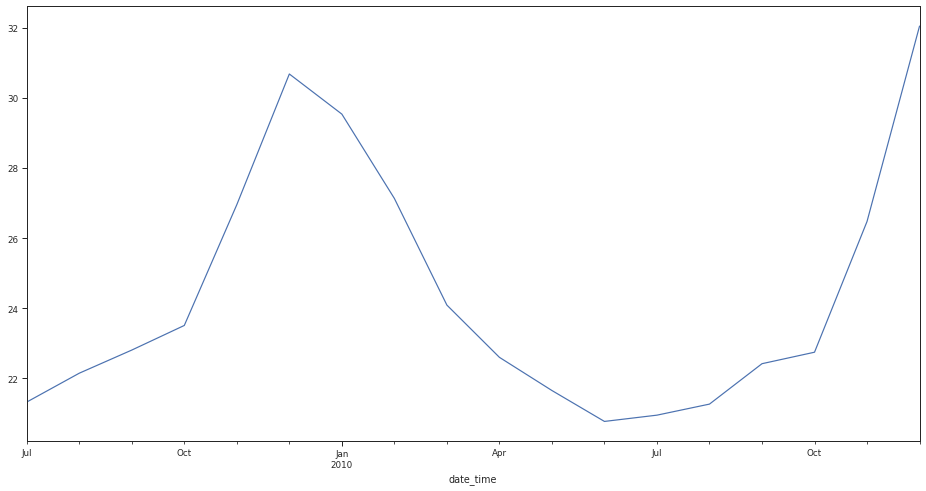

In [65]:
monthly_avg_load.plot(figsize=(16,8), legend=False)
#tikzplotlib.clean_figure()
file_path=os.path.join(tikz_path,'monthly_avg_load.tex')
tikzplotlib.save(
    file_path,
    strict=False,
    add_axis_environment=False
    #axis_height=".8\\textheight",
    #axis_width=".8\\textwidth",
    #extra_axis_parameters=['forecast plot style']
)

In [66]:
montly_avg_load_per_weekday=mean_load.groupby([mean_load.index.year,mean_load.index.month,mean_load.index.dayofweek]).mean()

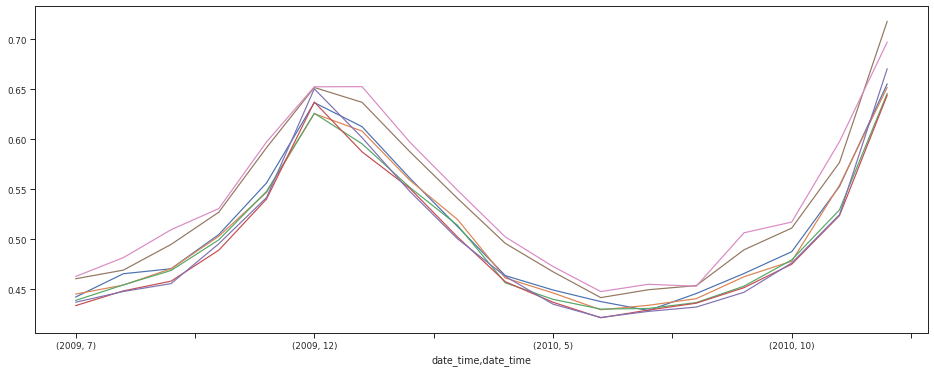

In [69]:
montly_avg_load_per_weekday.unstack().plot(figsize=(16,6), legend=False)
#tikzplotlib.clean_figure()
file_path=os.path.join(tikz_path,'montly_avg_load_per_weekday.tex')
tikzplotlib.save(
    file_path,
    strict=False,
    add_axis_environment=False
    #axis_height=".8\\textheight",
    #axis_width=".8\\textwidth",
    #extra_axis_parameters=['forecast plot style']
)

In [72]:
montly_avg_load_per_weekday.unstack()

load                                          \
date_time                   0         1         2         3         4   
date_time date_time                                                     
2009      7          0.442373  0.445353  0.438994  0.433799  0.437188   
          8          0.465703  0.454368  0.454548  0.448549  0.447941   
          9          0.470691  0.470696  0.468956  0.458276  0.455832   
          10         0.504922  0.503194  0.499619  0.489276  0.495704   
          11         0.556521  0.547122  0.548102  0.540427  0.541959   
          12         0.636863  0.625831  0.626175  0.637432  0.650661   
2010      1          0.612803  0.608390  0.595701  0.587632  0.601820   
          2          0.561376  0.559253  0.552084  0.551108  0.548087   
          3          0.512935  0.519980  0.514210  0.502480  0.500647   
          4          0.463845  0.461491  0.456647  0.457749  0.463097   
          5          0.449440  0.446513  0.440111  0.437201  0.435283   
          6          0.437839  0.429662  0.430321  0.421669  0.421963   
          7          0.428936  0.434143  0.430982  0.429388  0.428079   
          8          0.445915  0.440748  0.436833  0.436259  0.432363   
          9          0.465956  0.462673  0.453266  0.451787  0.447149   
          10         0.487767  0.478228  0.479581  0.475242  0.476470   
          11         0.553040  0.554218  0.529623  0.523863  0.524758   
          12         0.655542  0.652089  0.646001  0.644284  0.670793   

                                         
date_time                   5         6  
date_time date_time                      
2009      7          0.460680  0.462928  
          8          0.469315  0.481787  
          9          0.495015  0.509729  
          10         0.527277  0.530895  
          11         0.591848  0.597555  
          12         0.652003  0.652701  
2010      1          0.637166  0.652821  
          2          0.587797  0.597362  
          3          0.541081  0.549173  
          4          0.496106  0.502591  
          5          0.467669  0.472940  
          6          0.441817  0.447872  
          7          0.449720  0.455169  
          8          0.453813  0.453217  
          9          0.489635  0.506645  
          10         0.511361  0.517400  
          11         0.576968  0.597826  
          12         0.718234  0.697384

In [109]:
date_time_index=pd.to_datetime(montly_avg_load_per_weekday.index.droplevel(2).drop_duplicates().to_frame(name=['year','month'],index=False).assign(DAY=1))
file_path=os.path.join(csv_path,'montly_avg_load_per_weekday.csv')
montly_avg_load_per_weekday.unstack().set_index(date_time_index,).droplevel(0,axis='columns').to_csv(file_path,index_label='t')

In [591]:
montly_avg_load_per_weekday.loc[2009].idxmax()

load    (12, 6)
dtype: object

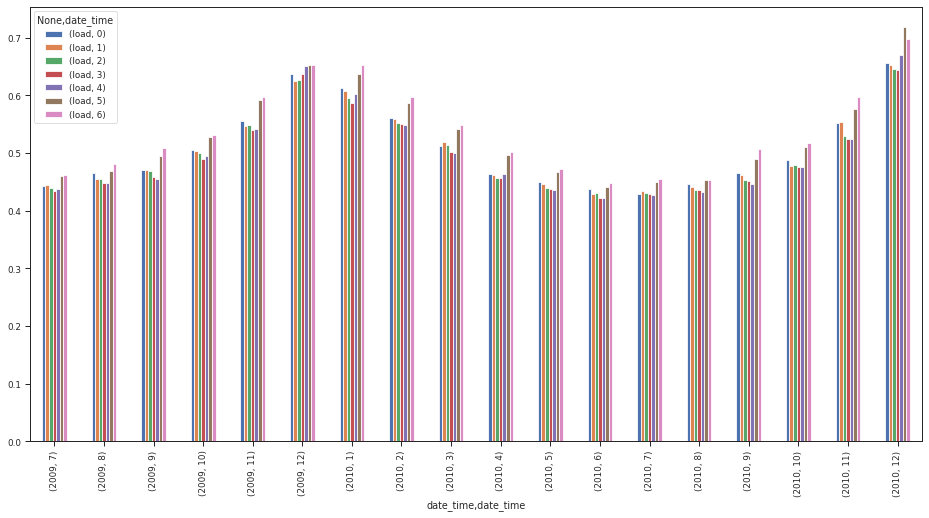

In [461]:
yearly_avg_load_per_weekday.unstack().plot.bar(figsize=(16,8))

In [110]:
daily_avg_load_per_weekday=mean_load.groupby([mean_load.index.time,mean_load.index.dayofweek]).mean()

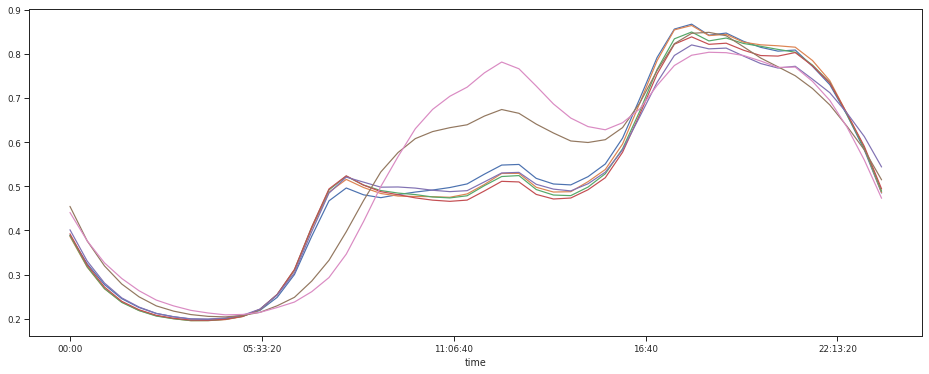

In [112]:
unstacked=daily_avg_load_per_weekday.unstack()
unstacked.plot(figsize=(16,6), legend=False)

In [117]:
file_path=os.path.join(csv_path,'daily_avg_load_per_weekday.csv')
unstacked.droplevel(0,axis='columns').reset_index(drop=True).to_csv(file_path,index_label='t')

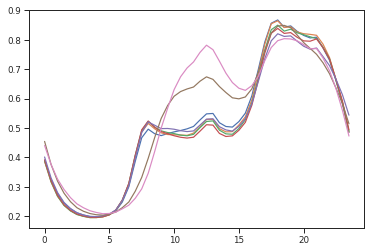

In [118]:
plt.plot(np.linspace(0,23.5,len(unstacked)),unstacked.values)
file_path=os.path.join(tikz_path,'daily_avg_load_per_weekday.tex')
tikzplotlib.save(
    file_path,
    strict=False,
    add_axis_environment=False
    #axis_height=".8\\textheight",
    #axis_width=".8\\textwidth",
    #extra_axis_parameters=['forecast plot style']
)

In [120]:
daily_avg_load_weekday_holiday=mean_load.groupby([mean_load.index.time,mean_load.index.dayofweek>=5]).mean()

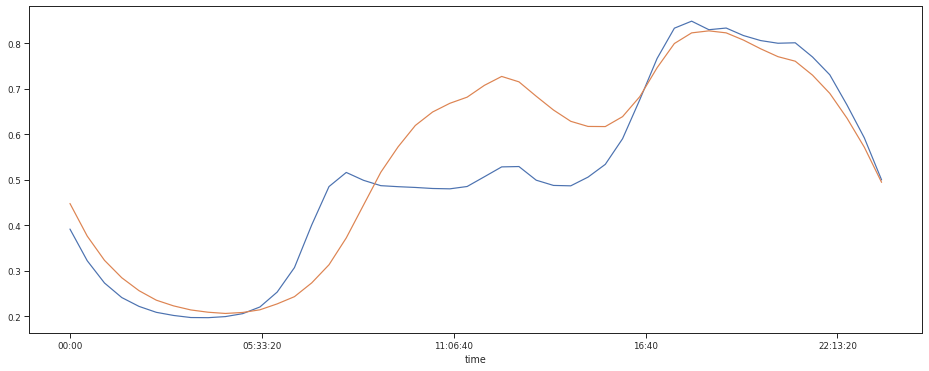

In [121]:
unstacked=daily_avg_load_weekday_holiday.unstack()
unstacked.plot(figsize=(16,6), legend=False)

In [124]:
file_path=os.path.join(csv_path,'daily_avg_load_weekday_holiday.csv')
unstacked.droplevel(0,axis='columns').reset_index(drop=True).to_csv(file_path,index_label='t')

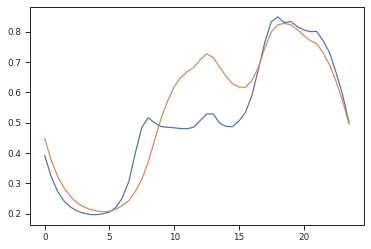

In [574]:
plt.plot(np.linspace(0,23.5,len(unstacked)),unstacked.values)
file_path=os.path.join(tikz_path,'daily_avg_load_weekday_holiday.tex')
tikzplotlib.save(
    file_path,
    strict=False,
    add_axis_environment=False
    #axis_height=".8\\textheight",
    #axis_width=".8\\textwidth",
    #extra_axis_parameters=['forecast plot style']
)

In [599]:
daily_load=mean_load.resample('D').sum()
daily_load=daily_load[daily_load!=0]

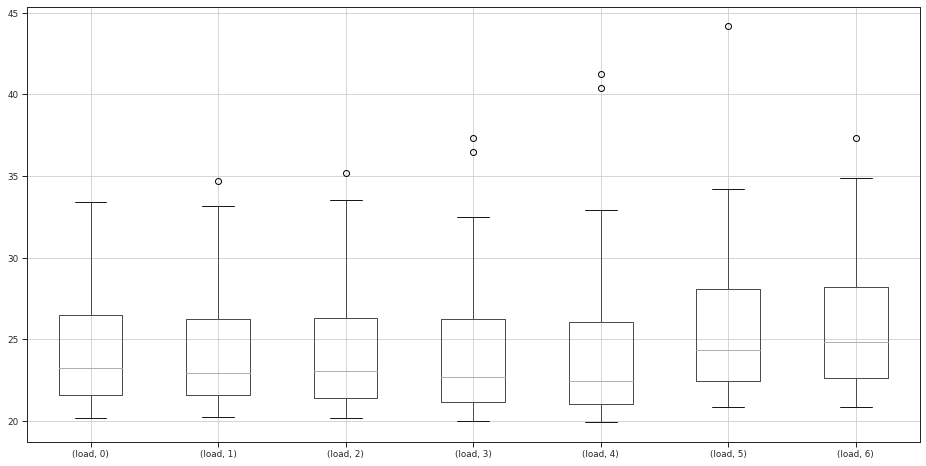

In [552]:
daily_load.pivot_table(index=daily_load.index, columns=daily_load.index.dayofweek).boxplot(
        figsize=(16,8))
file_path=os.path.join(tikz_path,'box_load_per_weekday.tex')
tikzplotlib.save(
    file_path,
    strict=False,
    add_axis_environment=False
    #axis_height=".8\\textheight",
    #axis_width=".8\\textwidth",
    #extra_axis_parameters=['forecast plot style']
)

In [125]:
daily_load.groupby(daily_load.index.dayofweek).mean().plot(figsize=(16,6),legend=False,c='royalblue')
file_path=os.path.join(tikz_path,'avg_load_per_weekday.tex')
tikzplotlib.save(
    file_path,
    strict=False,
    add_axis_environment=False
    #axis_height=".8\\textheight",
    #axis_width=".8\\textwidth",
    #extra_axis_parameters=['forecast plot style']
)

AttributeError: 'Index' object has no attribute 'dayofweek'

In [609]:
daily_load.index.dayofweek, daily_load.index.year, daily_load.index.month

(Int64Index([1, 2, 3, 4, 5, 6, 0, 1, 2, 3,
             ...
             2, 3, 4, 5, 6, 0, 1, 2, 3, 4],
            dtype='int64', name='date_time', length=536),
 Int64Index([2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009,
             ...
             2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010],
            dtype='int64', name='date_time', length=536),
 Int64Index([ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
             ...
             12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
            dtype='int64', name='date_time', length=536))

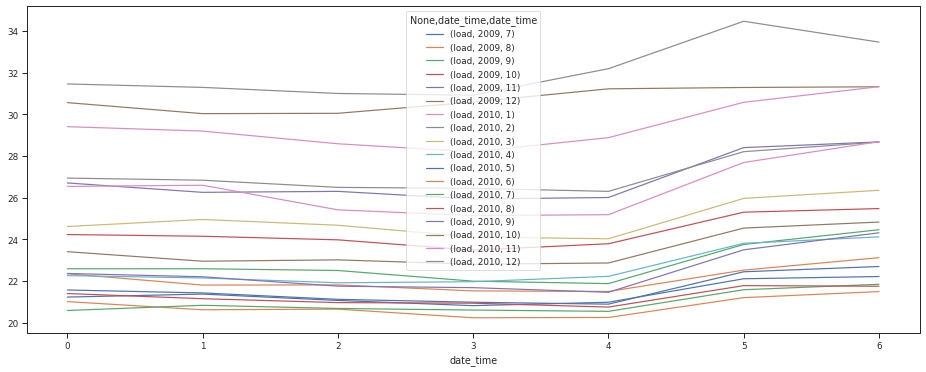

In [613]:
daily_load.groupby([daily_load.index.dayofweek, daily_load.index.year, daily_load.index.month]).mean().unstack([1,2]).plot(figsize=(16,6))

In [130]:
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

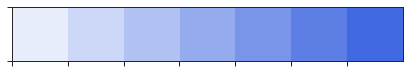

In [131]:
pal = sns.light_palette("royalblue", len(dayOfWeek))
#pal = sns.color_palette('Blues',n_colors=len(dayOfWeek))
sns.palplot(pal)

In [132]:
file_path=os.path.join(tikz_path,'load_per_weekday.tex')
lines = []
for i,c in enumerate(pal):
    lines.append(f'\\definecolor{{{dayOfWeek[i].lower()}Color}}{{rgb}}{{{c[0]},{c[1]},{c[2]}}}')
for i,v in load_per_weekday.groupby(load_per_weekday.index.get_level_values(2)):
    lines.append(f'\\addplot[draw={dayOfWeek[i].lower()}Color,fill={dayOfWeek[i].lower()}Color!50] coordinates {{')
    for c,l in enumerate(v):
        lines.append(' '*4 + str((c,l)))
    lines.append('};')
    lines.append(f'\\addlegendentry{{{dayOfWeek[i]}}}')
    
#with open(file_path, 'w+') as f:
#    f.write('\n'.join(lines))

In [215]:
load_per_hour=mean_load.groupby(mean_load.index.hour).sum().sort_index()

In [216]:
load_per_hour

date_time
0     396.858363
1     288.038147
2     238.572963
3     218.355563
4     214.052927
5     226.666338
6     285.224791
7     427.496489
8     511.328307
9     535.336441
10    559.039917
11    571.672133
12    611.074337
13    603.117953
14    565.001195
15    583.017675
16    683.023540
17    844.384710
18    890.114774
19    876.391066
20    848.657862
21    825.104918
22    732.872143
23    577.934404
Name: load, dtype: float64

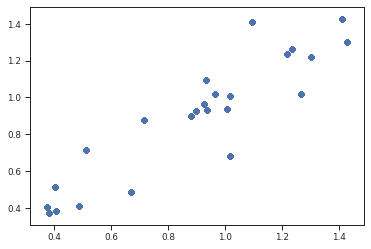

In [161]:
plt.scatter(x=resample_hour[resample.index.hour],y=resample_hour[resample.index.hour+1])

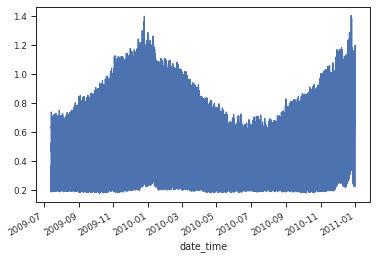

In [194]:
mean_load.plot()

In [207]:
load_per_day=mean_load.groupby(mean_load.index.date).sum().sort_index()

In [213]:
load_per_day

2009-07-14    21.476553
2009-07-15    20.797150
2009-07-16    20.808281
2009-07-17    20.375119
2009-07-18    22.126251
                ...    
2010-12-27    33.407238
2010-12-28    31.188188
2010-12-29    30.291003
2010-12-30    29.484801
2010-12-31    30.643238
Name: load, Length: 533, dtype: float64

In [206]:
resample_day[resample.index.day+1]

2009-07-29    21.338215
2009-07-29    21.338215
2009-07-29    21.338215
2009-07-29    21.338215
2009-07-29    21.338215
                ...    
2009-08-15    22.438868
2009-08-15    22.438868
2009-08-15    22.438868
2009-08-15    22.438868
2009-08-15    22.438868
Name: load, Length: 12864, dtype: float64

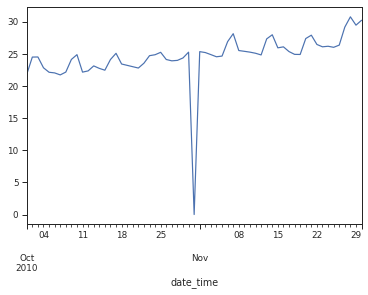

In [159]:
resample_day['10-2010':'11-2010'].plot()

## Add Weather and history data

### (Down)load historical weather data 

In [10]:
weather_file_path=os.path.join(data_path,'weather.csv')

In [11]:
start_date,end_date=data.date_time.min(),data.date_time.max()
start_date,end_date

NameError: name 'data' is not defined

In [12]:
frequency = 1
start_date_str=start_date.strftime('%d-%b-%Y').upper()
end_date_str=end_date.strftime('%d-%b-%Y').upper()

api_key = 'b8c3ab971ca64440bf1102230202303'

if os.path.exists(weather_file_path):
    weather_data = pd.read_csv(weather_file_path,
                               parse_dates=['date_time'],
                               index_col=['date_time'],
                               usecols=['date_time','maxtempC', 'mintempC', 'sunHour', 'uvIndex', 'tempC'],
                               header=0,
                               infer_datetime_format=True)
else:
    weather_data=dowload_weather_data(api_key,frequency,start_date_str,end_date_str)
    weather_data=weather_data[0]
    weather_data.to_csv(weather_file_path,index=False)
    weather_data = weather_data[['date_time','maxtempC', 'mintempC', 'sunHour', 'uvIndex', 'tempC']]
    
weather_data.head()

NameError: name 'start_date' is not defined

In [ ]:
# drop duplicated rows
weather_data=weather_data[~weather_data.index.duplicated()]

### How is the temerature distributed?

In [ ]:
weather_data.tempC.plot.hist()

In [ ]:
data=pd.merge_ordered(
    left=data,
    right=weather_data.tempC,
    on='date_time',
    fill_method='ffill',
    how='left')

In [ ]:
if data.isnull().any().sum() != 0:
    raise Error('Data contains NaNs!!')

In [ ]:
data.head(8000)

In [ ]:
mem_usage(data)

### Irish holidays

In [592]:
from holidays import Ireland as holidays_ir

holidays = holidays_ir()

In [594]:
h = holidays[start_date:end_date]
h

[datetime.date(2009, 8, 3),
 datetime.date(2009, 10, 26),
 datetime.date(2009, 12, 25),
 datetime.date(2009, 12, 26),
 datetime.date(2009, 12, 28),
 datetime.date(2010, 1, 1),
 datetime.date(2010, 3, 17),
 datetime.date(2010, 4, 5),
 datetime.date(2010, 5, 3),
 datetime.date(2010, 6, 7),
 datetime.date(2010, 8, 2),
 datetime.date(2010, 10, 25),
 datetime.date(2010, 12, 25),
 datetime.date(2010, 12, 26),
 datetime.date(2010, 12, 27),
 datetime.date(2010, 12, 28)]

In [593]:
is_holiday = np.uint8((data.date_time.dt.weekday > 4) | np.isin(data.date_time.dt.date,h))

KeyboardInterrupt: 

In [ ]:
data['is_holiday']=is_holiday

In [ ]:
data.head()

In [ ]:
mem_usage(data)

In [ ]:
data.dtypes